<a href="https://colab.research.google.com/github/bmarci99/Crypto_trading/blob/main/FFNN_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data processing

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


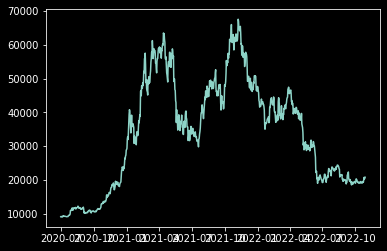

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')

dataurl = "https://raw.githubusercontent.com/helloWorld199/NAML-project-/main/Prices.csv"

# load the dataset
df = pd.read_csv(dataurl)
#print(df.dtypes)

df['Date'] = pd.to_datetime(df['Date'])
#print(df.dtypes)

df.set_index('Date', inplace=True) 
df = df.drop('Symbol', axis=1)

print(df.dtypes)
plt.plot(df['Close'])

FEEDFORWARD NEURAL NETWORK APPROACH

The idea is to give as input a certain number of past close prices, based on which we can predict the next one.

In [41]:
#Used to define a sequential model (which is the case of ff nn layers) 
from keras.models import Sequential
#FC layers ==> dense layers
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
new_df = pd.read_csv(dataurl)

#dataframe containing only close prices information
close_prices = new_df['Close']

#converting to np.array
dataset = close_prices.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (dataset.shape[0], 1))
#Common activation functions (sigmoid, tanh etc.) don't work well with big numbers such 
#BTC prices ==> we scale them
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

print(dataset[:5])

train_size = int(len(dataset) * 0.66)
valid_size = int(len(dataset) * 0.20)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[:train_size, :], dataset[train_size:(train_size + valid_size), :], dataset[train_size + valid_size:, :]

print(train_size, train.shape, valid_size, valid.shape, test_size, test.shape)

#Let's divide the dataset such we have some inputs related to some outputs.
#e.g.: we take dataset[0:7] as input, and consider dataset[7] as the output,
# we take dataset[1:8] as input, and consider dataset[8] as the output and so on.

def to_IO_data(dataset, w_size):
  x=[]
  y=[]
  for i in range(len(dataset) - w_size):
    window = dataset[i:w_size+i, 0]
    x.append(window)
    y.append(dataset[w_size+i, 0])
  return np.array(x), np.array(y)

window_size = 7
trainX, trainY = to_IO_data(train, window_size)
validX, validY = to_IO_data(valid, window_size)
testX, testY = to_IO_data(test, window_size)

#print(train[:10], trainX[:2,:], trainY[:2])
print("Shape of training set: {}".format(trainX.shape))
print("Shape of labels of training set: {}".format(trainY.shape))
print("Shape of training set: {}".format(validX.shape))
print("Shape of labels of training set: {}".format(validY.shape))
print("Shape of test set: {}".format(testX.shape))
print("Shape of labels of test set: {}".format(testY.shape))

[[0.00109503]
 [0.00263934]
 [0.0008457 ]
 [0.00022843]
 [0.00100091]]
562 (562, 1) 170 (170, 1) 120 (120, 1)
Shape of training set: (555, 7)
Shape of labels of training set: (555,)
Shape of training set: (163, 7)
Shape of labels of training set: (163,)
Shape of test set: (113, 7)
Shape of labels of test set: (113,)


In [42]:
#Construction of FFNN
model = Sequential()
model.add(Dense(64, input_dim=window_size, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                512       
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(trainX, trainY, validation_data=(validX, validY),
          verbose=2, epochs=100)

In [46]:
train_predict = model.predict(trainX)
valid_predict = model.predict(validX)
test_predict = model.predict(testX)

print(train_predict.shape, valid_predict.shape, test_predict.shape)

#going back to original prices
train_predict = scaler.inverse_transform(train_predict)
trainY_inverse = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY_inverse = scaler.inverse_transform([testY])

import math
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

4/4 [==============================] - 0s 4ms/step
(555, 1) (163, 1) (113, 1)
Train Score: 1660.47 RMSE
Test Score: 840.12 RMSE


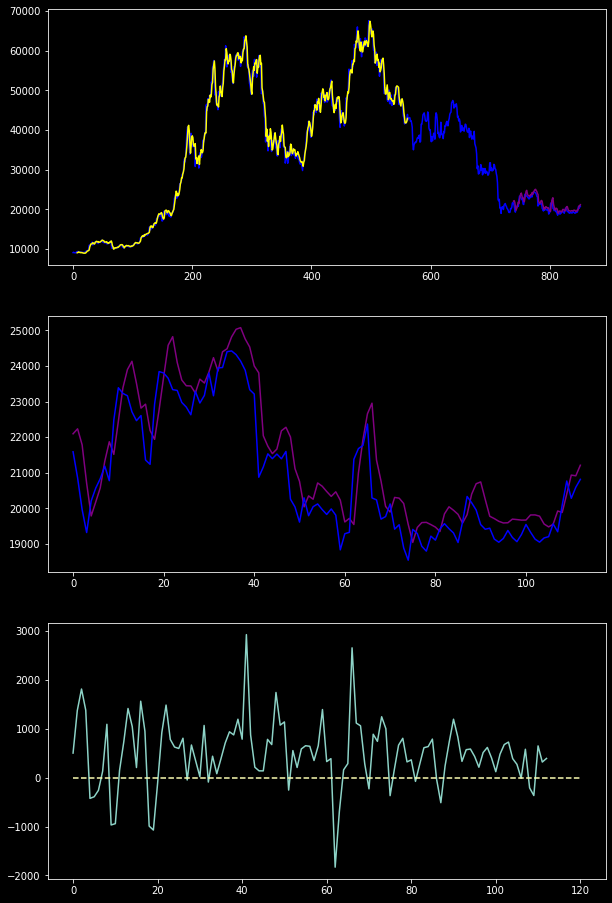

In [65]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(train_predict)+window_size, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+len(valid_predict)+(window_size*3):len(dataset), :] = test_predict

fig, ax = plt.subplots(3, figsize=(10,16))


# plot baseline and predictions
ax[0].plot(scaler.inverse_transform(dataset), color='blue')
ax[0].plot(trainPredictPlot, color='yellow')
ax[0].plot(testPredictPlot, color='purple')
actual_values = scaler.inverse_transform(dataset[(train_size + valid_size) + 7:])
ax[1].plot(test_predict, color='purple')
ax[1].plot(actual_values, color='blue')
ax[2].plot(test_predict-actual_values)
ax[2].plot([0,120], [0,0], '--')
plt.show()

